# The spelled-out intro to language modeling: building makemore

Following: https://www.youtube.com/watch?v=PaCmpygFfXo&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=2

In [1]:
from pathlib import Path
from collections import defaultdict

In [2]:
data = Path('../data')

# Exploring bigrams (0:00 - 0:15:00)

Tasks done in the video:
- Load the dataset
- Explore
    - min/max length of names
    - number of names
- count all the bigrams into a dictionary
    - dedicated \<S\> and \<E\> tokens

In [3]:
names = (data/'names.txt').open().read().splitlines()
names[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [4]:
len(names)

32033

In [5]:
min(len(name) for name in names), max(len(name) for name in names)

(2, 15)

In [6]:
bigrams = defaultdict(int)
start = '<S>'
end = '<E>'

for name in names:
    name = [start] + list(name) + [end]
    for ch1,ch2 in zip(name, name[1:]):
        bigrams[(ch1,ch2)] += 1

In [7]:
sorted((bigram_tuples for bigram_tuples in bigrams.items()), key=lambda b: b[1], reverse=True)[:10]

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963)]

# Bigrams into torch.Tensor ( - 00:36:00, skipping efficiency until 00:50:00)

- Goal: n*n matrix that holds the bigram count in each cell
- No more dedicated start/stopping tokens, instead use . for both
- sample from the model
    - start with the starting dot
    - choose random next character according to probabilities in that row (torch.multinomial)
    - repeat until ending-dot is reached
    - Use torch.Generator for comparability

### Bigrams to Tensor

Extracting all used characters:

In [8]:
characters = set('.')
characters = characters.union(set(''.join(names)))
characters

{'.',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z'}

In [9]:
import torch

In [10]:
stoi = {char: i for i,char in enumerate(characters)}
itos = {i: char for char,i in stoi.items()}
stoi

{'n': 0,
 'm': 1,
 'y': 2,
 'f': 3,
 'w': 4,
 'q': 5,
 's': 6,
 'v': 7,
 't': 8,
 'e': 9,
 'p': 10,
 'd': 11,
 'b': 12,
 'u': 13,
 '.': 14,
 'z': 15,
 'c': 16,
 'k': 17,
 'j': 18,
 'r': 19,
 'i': 20,
 'o': 21,
 'l': 22,
 'x': 23,
 'h': 24,
 'g': 25,
 'a': 26}

In [11]:
bigrams = torch.zeros((len(characters), len(characters)))
start = '.'
end = '.'

for name in names:
    name = [start] + list(name) + [end]
    for ch1,ch2 in zip(name, name[1:]):
        row_index = stoi[ch1]
        col_index = stoi[ch2]
        bigrams[row_index, col_index] += 1

### Sampling

Counts for characters following the start character:

In [12]:
bigrams[stoi[start],:]

tensor([1146., 2538.,  535.,  417.,  307.,   92., 2055.,  376., 1308., 1531.,
         515., 1690., 1306.,   78.,    0.,  929., 1542., 2963., 2422., 1639.,
         591.,  394., 1572.,  134.,  874.,  669., 4410.])

Drawing a sample with counts as weights:

In [13]:
next_idx = torch.multinomial(bigrams[stoi[start],:], 1, replacement=True).item()
next_char = itos[next_idx]
next_char

'a'

Repeat until the stopping token is drawn:

In [14]:
g = torch.Generator().manual_seed(2147483647)

for i in range(20):
    name = start
    while True:
        next_idx = torch.multinomial(bigrams[stoi[name[-1]],:], 1, replacement=True, generator=g).item()
        next_char = itos[next_idx]
        name += next_char

        if next_char == end:
            break


    print(name)

.jarynahto.
.jahoora.
.dan.
.l.
.kan.
.heten.
.kla.
.iano.
.beiysh.
.j.
.besush.
.s.
.trio.
.za.
.don.
.pal.
.lmiynanymi.
.ain.
.krisigrakevir.
.rnsen.


Sanity-Check: Drawing with uniform probability

In [15]:
g = torch.Generator().manual_seed(2147483647)
weights = torch.ones(len(characters))

for i in range(20):
    name = start
    while True:
        next_idx = torch.multinomial(weights, 1, replacement=True, generator=g).item()
        next_char = itos[next_idx]
        name += next_char

        if next_char == end:
            break


    print(name)

.klrmmghykjkugkxoa.
.elm.
.odziwplwtwnk.
.zguiawokdmiwqidcspwvevlbqpsdjrkbx.
.ejvttaxbonewfhnfqduaofp.
.pzqzlpljvvkjpjnfsytmydrbczdfnhihxycud.
.oorhwvasqhtxkcbwcw.
.xaldghrkpszjkkcshrixdszostlxsturoggzilfllkcsfygwpfzotdmpdtk.
..
.ckuubbmzjwkgnvracxnabvepe.
.m.
.vaaoobrglkjosomxmlrwy.
.xlbujgclvjrsvcrtv.
.uxmskurpwlyt.
.vlzeevhtdxwbijwdx.
.mvagd.
.klnbsriwkevl.
.fwzewqirodvwcnfscprhqkpfrupxvoaqrnxzsbsphsbgbvyqvcpwczlwixnwbagrkijythtfw.
.qeoounhigrbsyumyzmm.
.gpczpoopsbfrmofkfvipubakiymerlhjivocdccevhowqpwarjzkqevzlohulinpbhszbdzafenidtweldwesmhfqlbcdidxxlohbguixgbvcamoxwlhslyzzsbwwctupqzupvpfkqkxinnxbhfbfpyunkoogepi.


# Loss function ( - 01:03:00)

- negative Likelihood is used to measure loss (product of probabilities)
- use logs for numerical purposes (turns into the sum)

In [16]:
P = bigrams / bigrams.sum(dim=1, keepdim=True)

In [17]:
for name in names[:2]:
    name = [start] + list(name) + [end]
    log_likelihood = 0
    n = 0
    for ch1,ch2 in zip(name, name[1:]):
        row_index = stoi[ch1]
        col_index = stoi[ch2]
        prob = P[row_index, col_index]
        log = torch.log(prob)
        log_likelihood += log
        n += 1
        
        print(f'({ch1}, {ch2}): {log}')
    print(f'Neg. Log-Likelihood: {-log_likelihood}')
    print(f'Mean Neg. Log-Likelihood: {-log_likelihood / n}')
    print('')

(., e): -3.0408453941345215
(e, m): -3.2793259620666504
(m, m): -3.6772043704986572
(m, a): -0.9417552351951599
(a, .): -1.6298604011535645
Neg. Log-Likelihood: 12.568990707397461
Mean Neg. Log-Likelihood: 2.513798236846924

(., o): -4.3981709480285645
(o, l): -2.550807476043701
(l, i): -1.7277942895889282
(i, v): -4.186665058135986
(v, i): -1.0382850170135498
(i, a): -1.9795759916305542
(a, .): -1.6298604011535645
Neg. Log-Likelihood: 17.511159896850586
Mean Neg. Log-Likelihood: 2.501594305038452



In [18]:
for name in ['andrej']:
    name = [start] + list(name) + [end]
    log_likelihood = 0
    n = 0
    for ch1,ch2 in zip(name, name[1:]):
        row_index = stoi[ch1]
        col_index = stoi[ch2]
        prob = P[row_index, col_index]
        log = torch.log(prob)
        log_likelihood += log
        n += 1
        
        print(f'({ch1}, {ch2}): {log}')
    print(f'Neg. Log-Likelihood: {-log_likelihood}')
    print(f'Mean Neg. Log-Likelihood: {-log_likelihood / n}')
    print('')

(., a): -1.9828919172286987
(a, n): -1.8295611143112183
(n, d): -3.259352207183838
(d, r): -2.562042474746704
(r, e): -2.012739896774292
(e, j): -5.917083740234375
(j, .): -3.7097861766815186
Neg. Log-Likelihood: 21.273456573486328
Mean Neg. Log-Likelihood: 3.03906512260437



# Neural Network Approach ( - 01:25:00)

- create training set
    - x tensor with first letter
    - y tensor with second letter
- use one-hot encoding to feed indices into nn
- "nn" is for now just a weight matrix and bias vector with grads
- output should be 27 dimensional
    - turn into "probabilities" by softmax
    

In [19]:
bigrams = torch.zeros((len(characters), len(characters)))
start = '.'
end = '.'
xs = []
ys = []

for name in names[:1]:
    name = [start] + list(name) + [end]
    for ch1,ch2 in zip(name, name[1:]):
        row_index = stoi[ch1]
        col_index = stoi[ch2]
        xs.append(row_index)
        ys.append(col_index)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [20]:
g = torch.Generator().manual_seed(2147483647)

W = torch.rand(size=(27,27), requires_grad=True, generator=g)
b = torch.rand(size=(1,27), requires_grad=True, generator=g)

In [21]:
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=27).float()
xenc

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1.]])

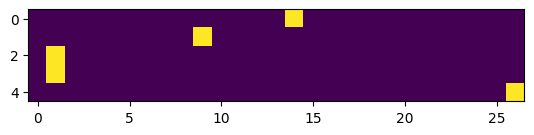

In [22]:
import matplotlib.pyplot as plt
plt.imshow(xenc)

In [23]:
# xenc: 5 x 27
# W: 27 x 27
# xenc @ W: 5 x 27
# b: 1 x 27

output = xenc@W + b
output.shape

torch.Size([5, 27])

In [24]:
counts = output.exp()
probs = counts / counts.sum(dim=1, keepdim=True)

probs[0,:]

tensor([0.0232, 0.0394, 0.0224, 0.0224, 0.0488, 0.0647, 0.0207, 0.0323, 0.0399,
        0.0263, 0.0227, 0.0293, 0.0259, 0.0311, 0.0560, 0.0365, 0.0460, 0.0530,
        0.0265, 0.0190, 0.0440, 0.0269, 0.0553, 0.0556, 0.0444, 0.0309, 0.0569],
       grad_fn=<SliceBackward0>)

In [25]:
F.softmax(output, dim=1)[0,:]

tensor([0.0232, 0.0394, 0.0224, 0.0224, 0.0488, 0.0647, 0.0207, 0.0323, 0.0399,
        0.0263, 0.0227, 0.0293, 0.0259, 0.0311, 0.0560, 0.0365, 0.0460, 0.0530,
        0.0265, 0.0190, 0.0440, 0.0269, 0.0553, 0.0556, 0.0444, 0.0309, 0.0569],
       grad_fn=<SliceBackward0>)

# Training loop ( - 01:47:00)

- get loss by taking nn-prob of actual next character
    - should be high --> neg. --> should be low
    - .log().mean()
- backward pass (set gradients to None)
- learning rate of 50 for now
- run training loop over all xs for now

In [60]:
# nn evaluation

xenc = F.one_hot(xs, num_classes=27).float()

output = xenc@W + b
probs = F.softmax(output, dim=1)

# actual next characters for each x in xs is in ys
predictions = probs[torch.arange(len(ys)), ys]
loss = predictions.log().mean()
loss

tensor(-3.2191, grad_fn=<MeanBackward0>)

In [61]:
# build training set with all data
bigrams = torch.zeros((len(characters), len(characters)))
start = '.'
end = '.'
xs = []
ys = []

for name in names:
    name = [start] + list(name) + [end]
    for ch1,ch2 in zip(name, name[1:]):
        row_index = stoi[ch1]
        col_index = stoi[ch2]
        xs.append(row_index)
        ys.append(col_index)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [69]:
# initialize nn
g = torch.Generator().manual_seed(2147483647)

W = torch.rand(size=(27,27), requires_grad=True, generator=g)
b = torch.rand(size=(1,27), requires_grad=True, generator=g)

for epoch in range(10):
    # forward pass
    xenc = F.one_hot(xs, num_classes=27).float()
    output = xenc@W + b
    probs = F.softmax(output, dim=1)

    # loss
    predictions = probs[torch.arange(len(ys)), ys]
    loss = predictions.log().mean()

    # backward pass
    W.grad = None
    b.grad = None

    loss.backward()

    # update
    with torch.no_grad():
        W -= 50 * W.grad
        b -= 50 * b.grad
    

    print(loss.item())

RuntimeError: a leaf Variable that requires grad is being used in an in-place operation.